### Light python event model used to simulate Juster events
- liquidity providing risk estimation
- different market maker behaviur testing

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from dynamics import calc_dynamics_by_freq
from coinbase_api import CoinbaseAPI
from plot import plot_dynamics_hists
from user import User
from run_events import run_random_event
from params_generation import generate_params, clipped_normal
from stats import agregate_event_state

sns.set_style("whitegrid")

In [3]:
import sys
sys.path.insert(0, '../../tests')
from event_model import EventModel

### Getting data to use as source of the price dynamics:

In [4]:
api = CoinbaseAPI()

pair = 'XTZ-USD'
event_durations = [3600, 21600, 86400]

dfs = {
    duration: api.get_history_prices(pair=pair, granularity=duration)
    for duration in event_durations
}

dynamics = {
    duration: calc_dynamics_by_freq(dfs[duration], f'{duration}S')
    for duration in event_durations
}

### Current data distribution:

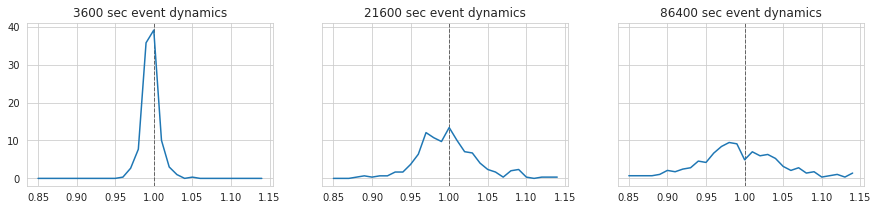

In [5]:
axes = plot_dynamics_hists(dynamics)

### Assumptions:

#### 1. Liquidity providers:
- there are two providers: one that adds liquidity in the event creation and second in random time during event (time selected using uniform distribution)
- first provider have expected market ratio that calculated as 

#### 2. Market expectation model:
- market ratio expectations are composed of different users expected ratio value
- users expected ratio value calculated before event creation and kept constant during event
- mean users expected ratio is equal to the real market ratio

#### 3. Users actions:
- user bets values are distributed exponentially
- bet pool is decided by difference between event pool and user expected pool
- MAYBE: user makes K bets proposals and selects one that leads event to the have the most close ratio to the user expectations (TODO: check this one, but I feel that it would change bet distribution)

## WIP
### TODO: process collected data: agregate, calculate stats
### TODO: collect metadata during event about bets and other params
### TODO: include DAO profit fee somewhere
### TODO: save data (?)
### TODO: analyze data to answer questions
- maybe using dash or another BI? find a way to make it interactive, so it would be easy to calculate mean event results

### ? TODO:
- make separate table with users ratio expecatations?

### To calculate expected market outcome for provider / users "clipped normal distribution" used, it looks like this:

<AxesSubplot:>

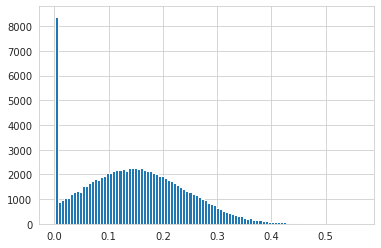

In [79]:
market_dynamics = dynamics[3600]
target_dynamics = 1.01

market_ratio = (market_dynamics >= target_dynamics).mean()
pd.Series(clipped_normal(market_ratio, 0.1, 100000)).hist(bins=100)

### TODO: there can be problems with event with analysing rates that too different from market ratio
- either need to change clipped_normal model
- either need to be very careful with events where target is not 0.5 and providers with big error rate
- but maybe it is OK, because if provider have big error: he suffers

### Running generation:

In [403]:
market_dynamics = dynamics[86400]
target_dynamics = 1.0
iterations = 10_000
results = []


for _ in tqdm(range(iterations)):
    params = generate_params(market_dynamics, target_dynamics)
    event_state = run_random_event(**params).to_dict()
    stats = agregate_event_state(event_state)

    results.append({
        **params,
        **event_state,
        **stats
    })

df = pd.DataFrame(results)

100%|██████████| 10000/10000 [00:39<00:00, 252.90it/s]


In [404]:
import json
import gzip

class EventSimulationData:
    def __init__(self, results):

        self.results = results
        self.df = pd.DataFrame(results)

    @classmethod
    def load(cls, filename):

        with gzip.open(filename, 'rt', encoding="ascii") as zipfile:
            json_bytes = zipfile.read()
            results = json.loads(json_bytes)

        return EventSimulationData(results)

    def save(self, filename):
        with gzip.open(filename, 'wt', encoding="ascii") as zipfile:
            json.dump(self.results, zipfile)

<AxesSubplot:>

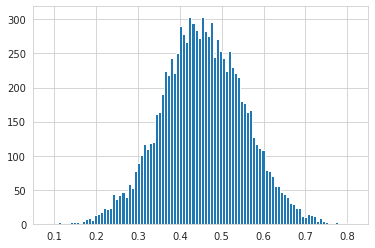

In [405]:
df.primary_provider_expected_a.hist(bins=100)

In [406]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ticks,10000.0,1.000000e+03,0.000000e+00,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
bet_chance,10000.0,1.005267e-01,5.741855e-02,1.012411e-03,5.122940e-02,1.001176e-01,1.499951e-01,1.999911e-01
users_count,10000.0,5.055730e+01,2.840957e+01,2.000000e+00,2.600000e+01,5.100000e+01,7.500000e+01,9.900000e+01
actual_dynamics,10000.0,1.001606e+00,7.458953e-02,8.190397e-01,9.647368e-01,9.968567e-01,1.034626e+00,1.585478e+00
target_dynamics,10000.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
fee,10000.0,1.936240e-02,1.762004e-02,0.000000e+00,1.000000e-03,1.000000e-02,3.000000e-02,5.000000e-02
primary_provider_amount,10000.0,1.090007e+08,9.757870e+07,1.000733e+07,3.835783e+07,7.932705e+07,1.483115e+08,1.093682e+09
primary_provider_expected_a,10000.0,4.539885e-01,9.909093e-02,8.586882e-02,3.875683e-01,4.529146e-01,5.217274e-01,8.132895e-01
primary_provider_expected_a_ape,10000.0,1.740072e-01,1.310822e-01,3.653675e-05,7.065676e-02,1.476166e-01,2.472443e-01,8.112149e-01
following_provider_amount,10000.0,1.107673e+08,9.997392e+07,1.000889e+07,3.918155e+07,7.978105e+07,1.495962e+08,9.321979e+08


### Support stat/filter funcs:

In [407]:
def filter_q(df, field, q=0.001):
    """ returns dataframe with excluded extreme q values,
        good to have anomaly values removed """

    series = df[ field ]
    is_above_low_q = series > series.quantile(q)
    is_bellow_high_q = series < series.quantile(1-q)
    return df[ is_above_low_q & is_bellow_high_q ]


def agg_stats_by_selector(df, selector):

    aggs = ['mean', 'median', 'min', 'max']
    stats = df.groupby(selector)['primary_provider_result'].agg(aggs)
    stats = stats.rename(columns=lambda c: f'{c}_result')
    stats['profitable_events_rate'] = df.groupby(selector).primary_provider_is_profit.mean()
    stats['events_count'] = df.groupby(selector).primary_provider_is_profit.count()
    return stats

### Calculating more stats:

In [408]:
df['primary_provider_result'] = df['diff_primary_provider'] / df['primary_provider_amount']
df['following_provider_result'] = df['diff_following_provider'] / df['following_provider_amount']

df['primary_provider_is_profit'] = df['diff_primary_provider'] > 0
df['primary_provider_is_loss'] = df['diff_primary_provider'] < 0
df['following_provider_is_profit'] = df['diff_following_provider'] > 0
df['following_provider_is_loss'] = df['diff_following_provider'] < 0

df['total_liquidity'] = df['pool_a'] * df['pool_b'] / 10**12

In [409]:
# calculating how much provider have percents from liquidity in pools
# (how many loquidity from bettors and how many from providers):

df['primary_provider_pool_a_share'] = df.apply(
    lambda r: r.primary_provider_expected_a * r.primary_provider_amount / r.pool_a,
    axis=1
)

df['primary_provider_pool_b_share'] = df.apply(
    lambda r: (1 - r.primary_provider_expected_a) * r.primary_provider_amount / r.pool_b,
    axis=1
)

In [410]:
def quantile_bins(series, bins_count):
    """ splits series in bins_count equally bins """
    return [series.quantile(k/bins_count) for k in range(bins_count + 1)]


In [411]:
def unpack_bins(df, field, bins):

    cats = pd.cut(df[field], bins=bins)
    df[f'{field}_bin_left'] = cats.map(lambda x: x.left)
    df[f'{field}_bin_right'] = cats.map(lambda x: x.right)
    df[f'{field}_bin_group'] = cats.map(lambda x: f'{x.left} - {x.right}')

    return df


def add_bins(df, field, bins_count=10, round_max_digits=0, spacer=np.linspace):
    bins = spacer(df[field].min(), df[field].max(), bins_count)
    df = unpack_bins(df, field, bins)

    return df

### TODO: make bins using quantiles:

In [412]:
bet_chance_bins = np.linspace(df['bet_chance'].min(), df['bet_chance'].max(), 11)
df = unpack_bins(df, 'bet_chance', bet_chance_bins)

total_liquidity_bins = np.linspace(df['total_liquidity'].min(), df['total_liquidity'].max(), 9)
df = unpack_bins(df, 'total_liquidity', total_liquidity_bins)

bins = quantile_bins(df['following_provider_to_primary_shares'], 5)
df = unpack_bins(df, 'following_provider_to_primary_shares', bins)

# df = add_bins(df, 'primary_provider_amount', bins_count=10, spacer=np.geomspace)
bins = quantile_bins(df['primary_provider_amount'], 10)
df = unpack_bins(df, 'primary_provider_amount', bins)

bins = quantile_bins(df['pool_a'], 10)
df = unpack_bins(df, 'pool_a', bins)

bins = quantile_bins(df['primary_provider_pool_a_share'], 10)
df = unpack_bins(df, 'primary_provider_pool_a_share', bins)

bins = quantile_bins(df['primary_provider_expected_a_ape'], 10)
df = unpack_bins(df, 'primary_provider_expected_a_ape', bins)

<AxesSubplot:>

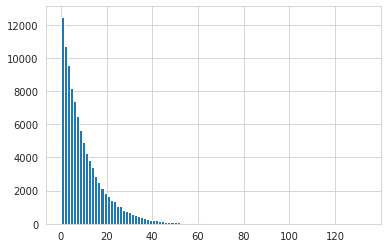

In [423]:
from numpy.random import exponential
pd.Series(exponential(10, 100000)).hist(bins=100)

In [424]:
df.columns[ df.columns.str.contains('bet') ]

Index(['bet_chance', 'bet_value_exp_scale', 'bet_ratio_deviation',
       'bet_chance_bin_left', 'bet_chance_bin_right', 'bet_chance_bin_group'],
      dtype='object')

In [413]:
df['primary_provider_expected_a_ape_bin_group'].value_counts()

0.0279 - 0.0559      1000
0.0559 - 0.0848      1000
0.0848 - 0.116       1000
0.116 - 0.148        1000
0.148 - 0.183        1000
0.183 - 0.224        1000
0.224 - 0.277        1000
0.277 - 0.357        1000
0.357 - 0.811        1000
3.65e-05 - 0.0279     999
Name: primary_provider_expected_a_ape_bin_group, dtype: int64

In [414]:
df['primary_provider_amount_bin_right'].value_counts().sort_index()

20239405.904       999
31855303.357      1000
45176821.785      1000
61084048.843      1000
79327053.743      1000
101451311.024     1000
129722805.495     1000
171084850.891     1000
238685155.577     1000
1093682294.208    1000
Name: primary_provider_amount_bin_right, dtype: int64

In [415]:
df['pool_a_bin_right'].value_counts().sort_index()

58050037.176       999
81848885.29       1000
103864110.963     1000
127249297.144     1000
150730761.763     1000
178138179.071     1000
213415193.71      1000
257667909.546     1000
332990276.132     1000
1053430116.408    1000
Name: pool_a_bin_right, dtype: int64

## Questions:

### How does fee affects liquidity provider returns?
- what are expected provider return with different fees?
- what are chance to have loss with different fees?

In [416]:
fee_stats = agg_stats_by_selector(df, 'fee')
fee_stats

,mean_result,median_result,min_result,max_result,profitable_events_rate,events_count
fee,,,,,,
0.000,0.000393,0.004226,-0.718603,1.062813,0.505452,1284
0.001,0.004701,0.007896,-0.668015,2.002546,0.521217,1249
0.005,0.007770,0.013697,-0.637503,1.168076,0.521633,1225
0.010,0.037033,0.033689,-0.678517,2.391634,0.561686,1305
0.020,0.068411,0.049928,-0.636003,3.316986,0.605809,1205
0.030,0.093990,0.075712,-0.583482,1.953312,0.625984,1270
0.040,0.147687,0.108471,-0.559683,2.643749,0.684298,1210
0.050,0.173506,0.129361,-0.512045,2.572002,0.698083,1252


<AxesSubplot:ylabel='fee'>

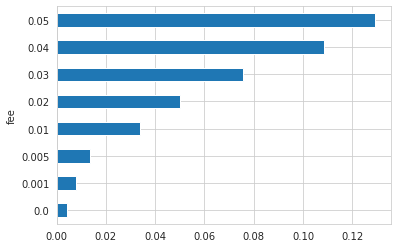

In [417]:
fee_stats.median_result.plot.barh()

### How liquidity provider error affects his returns?

- absolute percent error distribution:

<AxesSubplot:>

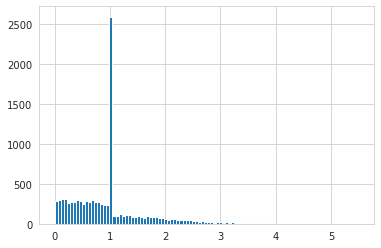

In [390]:
df['primary_provider_expected_a_ape'].hist(bins=100)

<AxesSubplot:xlabel='primary_provider_expected_a_ape', ylabel='primary_provider_result'>

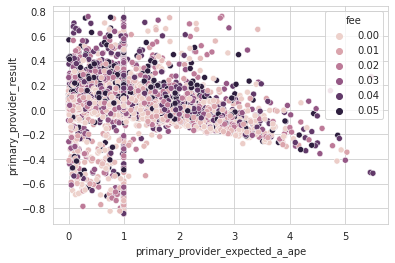

In [391]:
sns.scatterplot(
    data=filter_q(df, 'primary_provider_result', 0.01),
    x='primary_provider_expected_a_ape',
    y='primary_provider_result',
    hue='fee'
)

### How bet density affects provider returns?

In [392]:
bet_chance_stats = agg_stats_by_selector(df, 'bet_chance_bin_right')

<AxesSubplot:ylabel='bet_chance_bin_right'>

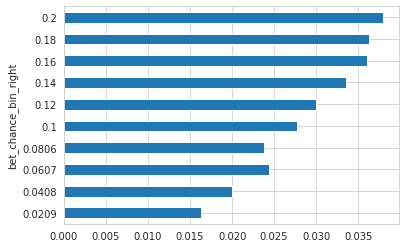

In [393]:
bet_chance_stats.median_result.plot.barh()

In [394]:
liquidity_stats = agg_stats_by_selector(df, 'total_liquidity_bin_right')

<AxesSubplot:ylabel='total_liquidity_bin_right'>

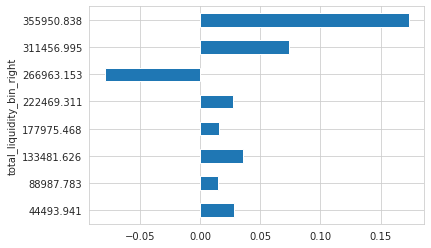

In [395]:
liquidity_stats.median_result.plot.barh()

<AxesSubplot:ylabel='provider_amount'>

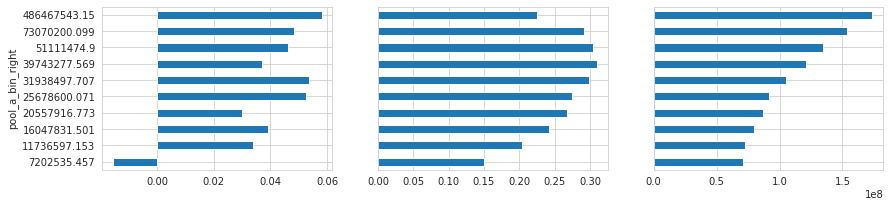

In [396]:
pool_stats = agg_stats_by_selector(df, 'pool_a_bin_right')
pool_mean_prov_shares = (df.groupby('pool_a_bin_right').primary_provider_pool_a_share.mean()
                             .rename_axis('mean_provider_share_in_a'))
pool_provider_amount = df.groupby('pool_a_bin_right').primary_provider_amount.mean().rename_axis('provider_amount')

fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
pool_stats.mean_result.plot.barh(ax=axes[0])
pool_mean_prov_shares.plot.barh(ax=axes[1])
pool_provider_amount.plot.barh(ax=axes[2])

<AxesSubplot:ylabel='primary_provider_amount_bin_right'>

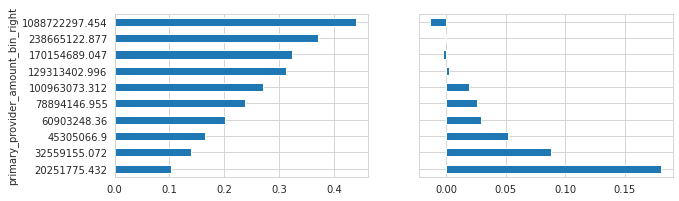

In [397]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

df.groupby('primary_provider_amount_bin_right').primary_provider_pool_a_share.mean().rename('provided_share_in_a').plot.barh(ax=axes[0])
df.groupby('primary_provider_amount_bin_right').primary_provider_result.mean().rename('provider_result').plot.barh(ax=axes[1])

## THIS:

<AxesSubplot:ylabel='primary_provider_pool_a_share_bin_right'>

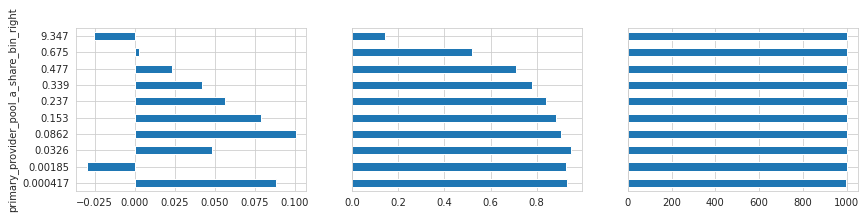

In [398]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)

grouper = df.groupby('primary_provider_pool_a_share_bin_right')

grouper.primary_provider_result.mean().rename('mean_result').plot.barh(ax=axes[0])
grouper.primary_provider_is_profit.mean().rename('mean_profitable_events_count').plot.barh(ax=axes[1])
grouper.primary_provider_is_profit.count().rename('events_count').plot.barh(ax=axes[2])

The lower liquidity -> the higher result? this is because the more liquidity -> the higher provider amount base
- but it looks like the size of the provided amount in pool is not so affected

KeyError: 'primary_provider_expected_a_ape_bin_right'

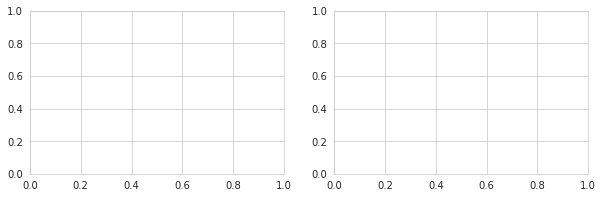

In [399]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

pool_a_provider_share_stats = agg_stats_by_selector(df, 'primary_provider_pool_a_share_bin_right')
ape = agg_stats_by_selector(df, 'primary_provider_expected_a_ape_bin_right')

pool_a_provider_share_stats.mean_result.plot.barh(ax=axes[0])
ape.mean_result.plot.barh(ax=axes[1])

<AxesSubplot:ylabel='primary_provider_expected_a_ape_bin_right'>

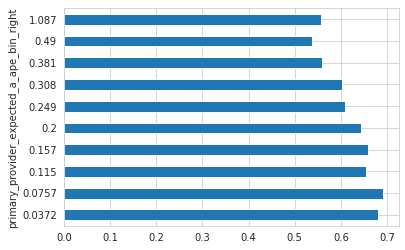

In [400]:
ape.profitable_events_rate.plot.barh()

<AxesSubplot:>

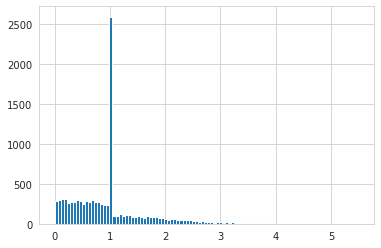

In [401]:
df.primary_provider_expected_a_ape.hist(bins=100)

<AxesSubplot:xlabel='primary_provider_expected_a_ape_bin_right', ylabel='mean_result'>

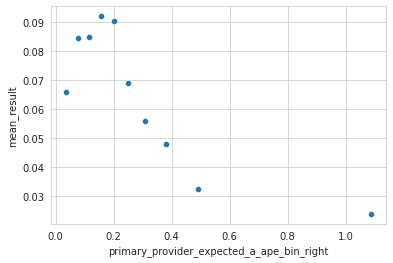

In [402]:
sns.scatterplot(
    data=ape.reset_index(),
    x='primary_provider_expected_a_ape_bin_right',
    y='mean_result',
    # y='profitable_events_rate'
)

In [ ]:
dynamics[86400]

### OK
- ape is just absolute percent error in expectations about mean market dynamics. This is not "real event error", this is error in market mean dynamics expectation
- so the question is: how accurate we can estimate this market dynamics? For events like price go up/down this value should be almost always inside [0.47, 0.53] I suppose, just intuition now, nothing more, need to analyze history data to have more concrete numbers.

In [233]:
0.53 / 0.47

1.1276595744680853

- so this is about 12% error max (if we expecting that market would be bully and it going to be bearish in this medium tern)
- the difference between 12% error and 2.5% error is about 1% of the profits per event (7% to 8%). Yes, the higher error - the lower yield, but I suppose we just can't get this "too high" errors
- again, (1) need to analyze historic data, (2) need to analyze another event types with +/-k% change, need to have more analytics about all of this

In [223]:
ape.profitable_events_rate

primary_provider_expected_a_ape_bin_right
0.0242    0.660466
0.0486    0.633900
0.0743    0.627000
0.101     0.604400
0.129     0.596700
0.16      0.576400
0.197     0.561600
0.243     0.562300
0.313     0.540700
0.84      0.532000
Name: profitable_events_rate, dtype: float64

### TODO: calculate agg different stats (all) of provider to median result

### What else heavily affects provider returns?

In [280]:
target = 'primary_provider_result'

result_corr = df.corr().loc[ target ].drop(target)
result_corr_df = pd.DataFrame({
    'corr': result_corr,
    'corr_abs': result_corr.abs()
})

result_corr_df.sort_values('corr_abs', ascending=False)

KeyError: 'primary_provider_result'

### Why primary_provider_amount is so impactive?

In [ ]:
provided_amount_stats = agg_stats_by_selector(df, 'primary_provider_amount_bin_right')
provided_amount_stats

WOW: looks like the less liquidity provided - the more profits

### more questions:
- Does users market expectance variance affect provider returns?
- How liquidity provider profit depends from bets frequency / size?
- What difference between risks and profits of the primary and the folowing providers?
- What are expected profits for providers for providers with different fees amount?
    - mean, median, q1 and q99 profits
- What mean APY is generated by events and is it possible to make APY predictions using expected market activity params?
- Providers return distribution, providers profit distribution, how many events should be negative so providers would be in K minus. What are the chances to have losses during infinite series of events, what chances to have -20%, -10%, 0%, +10% etc. Plot between profits in K events and chances to have this profit.

    - типа на дистанции 10000 событий смотреть график вероятности распределения прибыли/убытка чтобы можно было понимать что при заданных условиях вероятность убытка ниже k% составляет столько-то (или вероятность прибыли)
    - либо вероятность что мы получим убыток больше чем K, в зависимости от... чего-то (числа ивентов может)

- как можно обмануть провайдера
- какой фи ставить


### Modelling:

In [217]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [218]:
X = df.dropna()
y = X.primary_provider_result
X = X[[
    'primary_provider_amount',
    'fee',
    'pool_a',
    'bet_chance',
    'bet_ratio_deviation',
    'users_count',
    'following_provider_amount',
    'actual_dynamics',
    'primary_provider_expected_a_ape',
    'primary_provider_expected_a'
]]

# TODO: primary_provider_is_profit classifier

In [219]:
# TODO: cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [220]:
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_train, y_train)

0.24842532311388654

In [221]:
regr.score(X_test, y_test)

0.2459132819925518

In [222]:
# feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = pd.Series(regr.feature_importances_, index=X.columns)
importances

primary_provider_amount            0.365074
fee                                0.369213
pool_a                             0.007232
bet_chance                         0.239775
bet_ratio_deviation                0.000008
users_count                        0.000000
following_provider_amount          0.010235
actual_dynamics                    0.000976
primary_provider_expected_a_ape    0.007093
primary_provider_expected_a        0.000394
dtype: float64